# Convolutional LSTM for coordinate prediction

### Imports

In [1]:
import pickle

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torchinfo import summary

from tqdm.auto import tqdm

# own
import common.action as action
import common.world as world
import common.plot as plot
import common.preprocess as preprocess
import common.nets as nets
import common.train as train
import common.tools as tools

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


### Load datasets

In [2]:
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

### Preprocess data

In [3]:
length_trajectory = 10
batch_size = 128

# split and shuffle data
train_data, test_data = preprocess.split_data_for_trajectories(oracle_reversed_data, 0.8, length_trajectory)
train_imgs, train_pos = preprocess.process_trajectory(train_data)
test_imgs, test_pos = preprocess.process_trajectory(test_data)

# stage data for the DataLoader
train_data = preprocess.ObtainDataset_notransform(train_imgs, train_pos)
test_data = preprocess.ObtainDataset_notransform(test_imgs, test_pos)

# DataLoader
dataset_loader_train_data = DataLoader(train_data, batch_size=batch_size, shuffle=True)
dataset_loader_test_data = DataLoader(test_data, batch_size=batch_size, shuffle=True)

### Initialize models

In [4]:
# initialize network
net_cnn = nets.CNN()
net_lstm = nets.LSTM(length_trajectory)

# checking values
h0 = torch.randn(2, 10, 100)
c0 = torch.randn(2, 10, 100)
x = torch.rand((64, 10, 3, 32, 32))

# check network
features = net_cnn(x)
out0, out1, hidden, c = net_lstm(features, h0, c0)

# shape statistics
tools.shapes(x, features, hidden, out0)

# network summary
print('SUMMARY CNN \n', summary(net_cnn, (64, 10, 3, 32, 32)), '\n')
print('SUMMARY LSTM \n', summary(net_lstm, ((64, 10, 480), (2, 10, 100), (2, 10, 100))))

input cnn: torch.Size([64, 10, 3, 32, 32]) - Batch size, Channel out, Height out, Width out
output cnn: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
input lstm: torch.Size([64, 10, 480])  - Batch size, sequence length, input size
hidden lstm: torch.Size([10, 100])
output lstm: torch.Size([64, 10]) 

SUMMARY CNN 
Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10, 480]             --
├─Conv2d: 1-1                            [640, 10, 28, 28]         760
├─Conv2d: 1-2                            [640, 20, 24, 24]         5,020
├─MaxPool2d: 1-3                         [640, 20, 12, 12]         --
├─Conv2d: 1-4                            [640, 30, 8, 8]           15,030
├─MaxPool2d: 1-5                         [640, 30, 4, 4]           --
Total params: 20,810
Trainable params: 20,810
Non-trainable params: 0
Total mult-adds (G): 2.85
Input size (MB): 7.86
Forward/backward pass size (MB): 108.95
P

### Train model

In [5]:
criterion = nn.MSELoss()
params = list(net_cnn.parameters()) + list(net_lstm.parameters())
optimizer = optim.Adam(params, lr=0.01)
episodes = 20

train_loss, test_loss, train_dis, test_dis, train_dis_item, test_dis_item  = train.train_ConvLSTM(dataset_loader_train_data, dataset_loader_test_data,
                                                                                   net_cnn, net_lstm, criterion, optimizer, episodes, length_trajectory)

Progress:   0%|          | 0/20 [00:00<?, ? Episode/s]

Epoch: 1, Train Loss: 460.7, Train distance: 19.81, , Test distance: 15.44
Epoch: 11, Train Loss: 182.5, Train distance: 11.89, , Test distance: 11.48
Finished Training


### Plot distance and loss over episodes

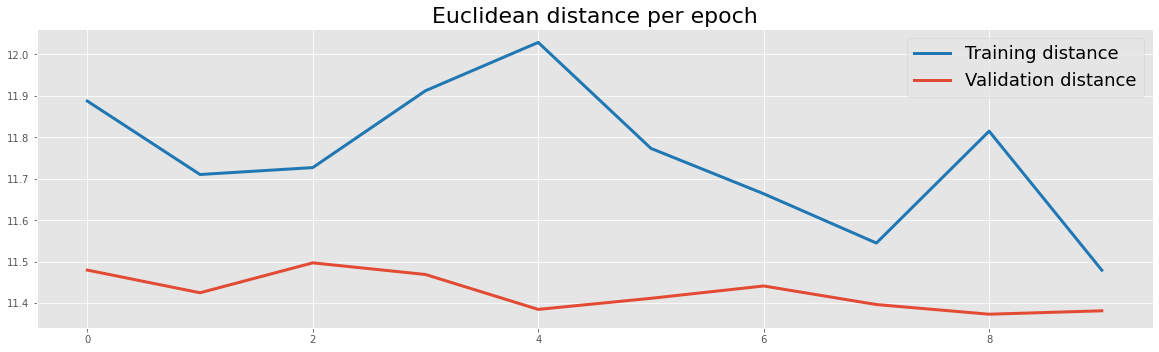

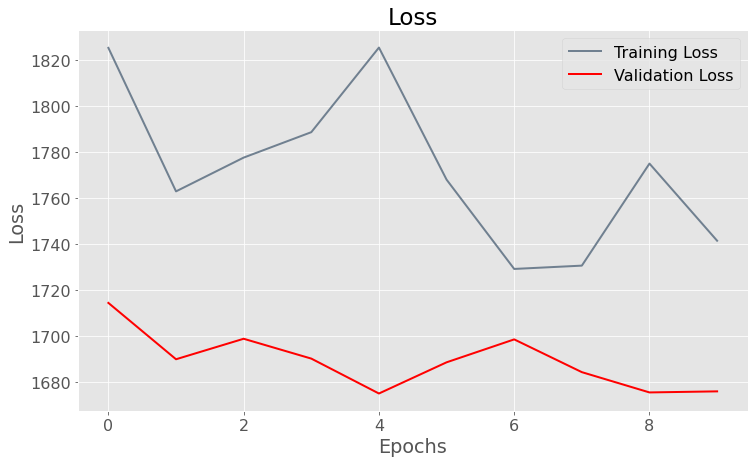

In [6]:
plot.plot_euclidean_distance(train_dis, test_dis)
plot.plot_losses(train_loss[10:], test_loss[10:])

### Histogram of the distribution shift (for test and training distances)

Training set 



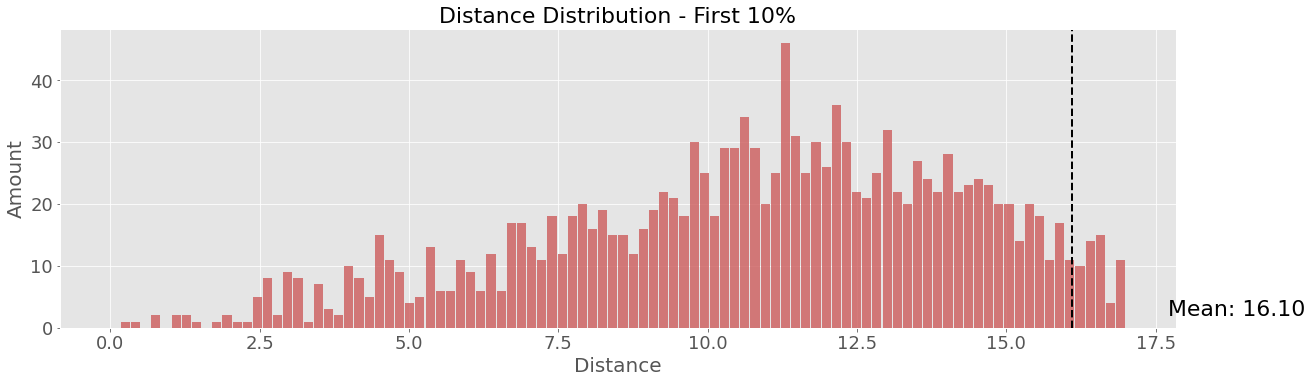

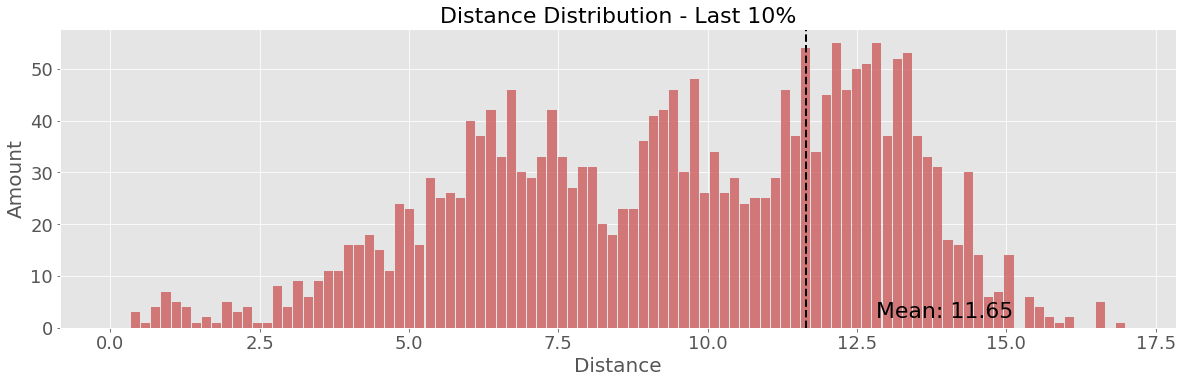

Validation set 



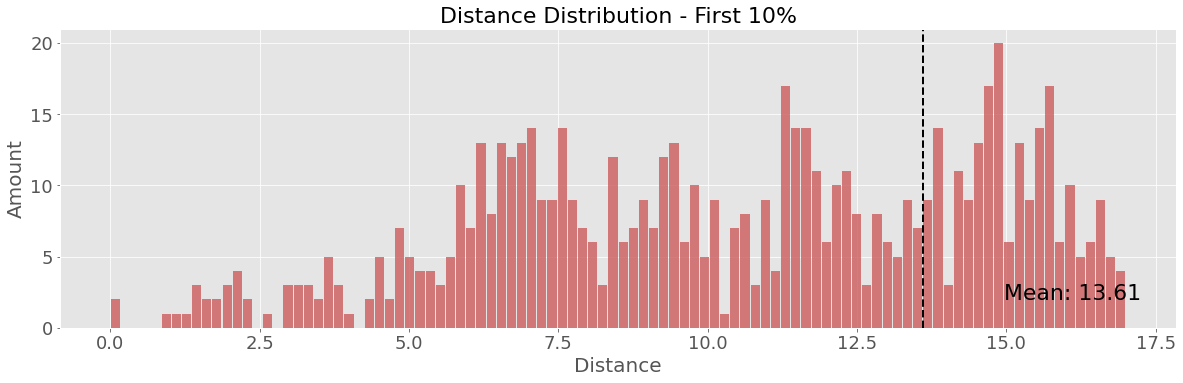

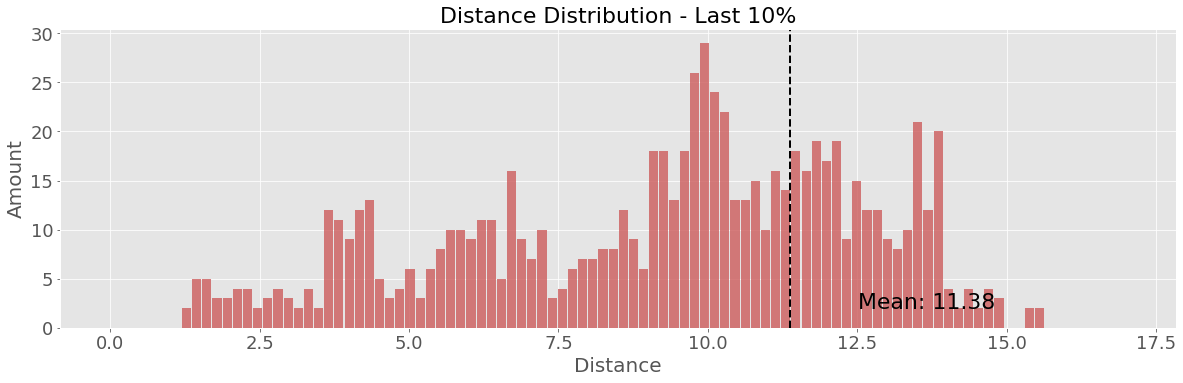

In [8]:
print('Training set \n')
plot.histo_distribution_shift(train_dis_item)
print('Validation set \n')
plot.histo_distribution_shift(test_dis_item)

### Histograms showing the training and validation distance distribution (for test and training distances)

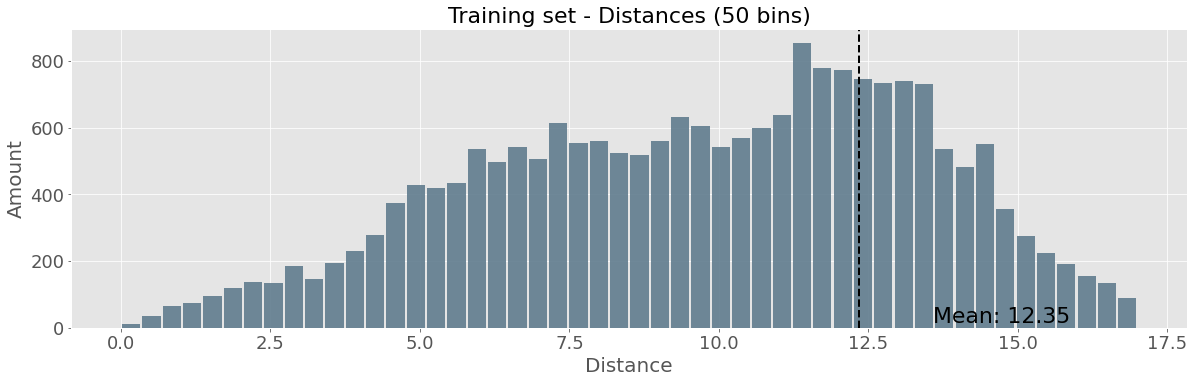

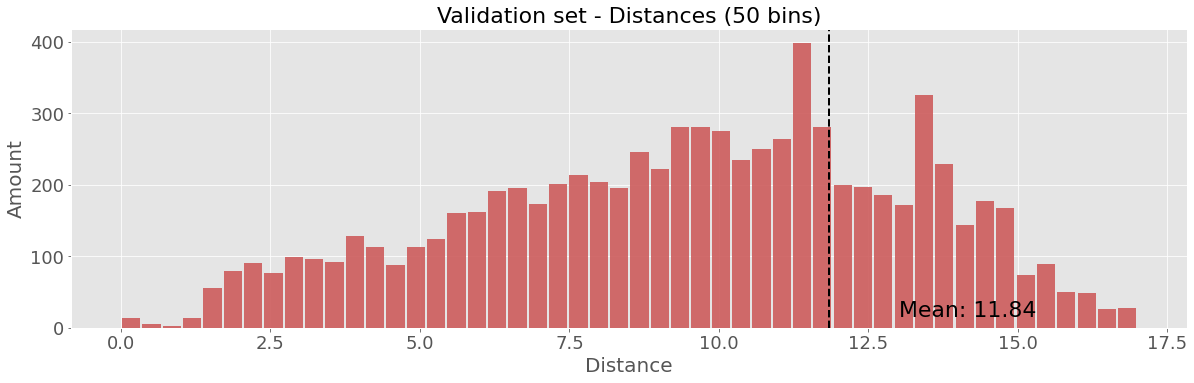

In [9]:
plot.histo_train_val(test_dis_item, train_dis_item)

### Save and load models